# MIE1624HF Final Project

### Due date: Dec. 18th, 2020
### Author: Tiana Wei 1004984216



### Main objectives: 
The goal of this project is to develop data science or machine learning models that **forecast COVID-19 cases with the aim of helping policymakers plan for the days and months ahead**, and take action to change the course of the pandemic for the better.

Cases count dataset: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data
Recovery dataset: 

Mobility dataset:
- from Apple: https://covid19.apple.com/mobility
    
Informed by this paper: COVID-19 open source data sets: a comprehensive survey (Shuja et al., 2020)
https://link.springer.com/article/10.1007/s10489-020-01862-6#Fn34


## 1. Data Cleaning – [5 Marks]

Depending on the algorithm you choose to use to model and find projections of the cases you will require a different format of data or approach and thus you will **design your data cleaning pipeline** accordingly. Please note that this is a time series data and so the number of cases on any given day is **the cumulative number**.

The data included in the analysis range within the dates of **1/26/20 to 12/2/20**.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# show plots inline for notebooks
%matplotlib inline

!pip install missingno
import missingno as msno

In [2]:
# read the covid confirmed and death cases from the time-series data (required dataset)
conf_df = pd.read_csv("time_series_covid19_confirmed_global.csv")
death_df = pd.read_csv("time_series_covid19_deaths_global.csv")

# make sure to only get data till Dec.2nd if you are reading a newer version of the dataset
conf_df = conf_df[:320]
death_df = death_df[:320]

### Since I live in Ontario now and COVID is getting worse day by day, I will analyze data in Ontario.

In [3]:
# take only the data for Ontario
conf_ON = conf_df[(conf_df['Province/State'] == 'Ontario')].reset_index(drop=True)
death_ON = death_df[(death_df['Province/State'] == 'Ontario')].reset_index(drop=True)

In [4]:
conf_ON = conf_ON.T[4:].reset_index()
death_ON = death_ON.T[4:].reset_index()

In [5]:
# assign column names
conf_ON.columns = ['date','confirmed']
death_ON.columns = ['date','dead']

### I am planning on building a SIR model so I need to read recover cases data as well

In [6]:
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports
from os import listdir
file_list = listdir("csse_covid_19_daily_reports/")
file_list = sorted(file_list)[1:]

In [7]:
## reading all the csv files from John Hopkins daily cases data since that's where I can find recovery data
dates = []
recov_ON = []
for x in file_list:
    # read the recovery cases from the daily data
    file = "csse_covid_19_daily_reports/" + str(x)
    recov_df = pd.read_csv(file)
    # if ontario is in the report, extract ontario's receovery data
    for i in range(len(recov_df)):
        province = [col for col in recov_df if col.startswith('Province')][0]
        if (recov_df[province][i] == 'Ontario') or (recov_df[province][i] == 'Toronto, ON'):
            dates.append(x[:-4])
            recov_ON = pd.concat((pd.DataFrame(recov_ON), pd.DataFrame(recov_df.iloc[i])), axis=1)


In [8]:
# take the recovered cases for each date with ON data
recov_ON = recov_ON.loc[['Recovered'],:]

In [9]:
# transpose the df and reset index
recov_ON = recov_ON.T.reset_index(drop=True)

<AxesSubplot:>

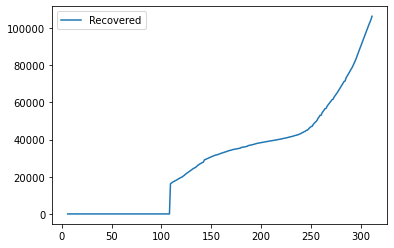

In [10]:
recov_ON.plot()

The recovery data from John Hopkins seems to be imcomplete before a certain date. Therefore, I am going to introduce another source for the recovery data in ON from https://data.ontario.ca/dataset/status-of-covid-19-cases-in-ontario/resource/ed270bb8-340b-41f9-a7c6-e8ef587e6d11.


In [11]:
ON_recov = pd.read_csv("covidtesting.csv")
ON_recov = ON_recov.loc[:,['Reported Date','Resolved']]

In [12]:
ON_recov.iloc[300]

Reported Date    2020-12-02
Resolved             101698
Name: 300, dtype: object

In [13]:
# change the format of date to match with infected and death dataframes
import datetime

dates_new = []
for i in ON_recov['Reported Date']:
    new = datetime.datetime.strptime(str(i), '%Y-%m-%d').strftime('%-m/%-d/%y') # have "-" before m to remove the leading 0
    dates_new.append(new)

In [14]:
# put date in dataframe format
dates_new = pd.DataFrame(dates_new)

In [15]:
# replace with new date formate
ON_recov['Reported Date'] = dates_new

In [16]:
# assign column names
ON_recov.columns = ['date','recovered']

In [17]:
# organizing the datasets to have the exact same date range
conf_ON = conf_ON[4:].reset_index(drop=True)
death_ON = death_ON[4:].reset_index(drop=True)
ON_recov = ON_recov[:301].reset_index(drop=True)

In [18]:
# merge infected, recovered, and death data on all dates
ON = pd.merge(conf_ON,ON_recov,on='date',how='left')
ON = pd.merge(ON, death_ON, on='date', how='left')

### Check missing data

<AxesSubplot:>

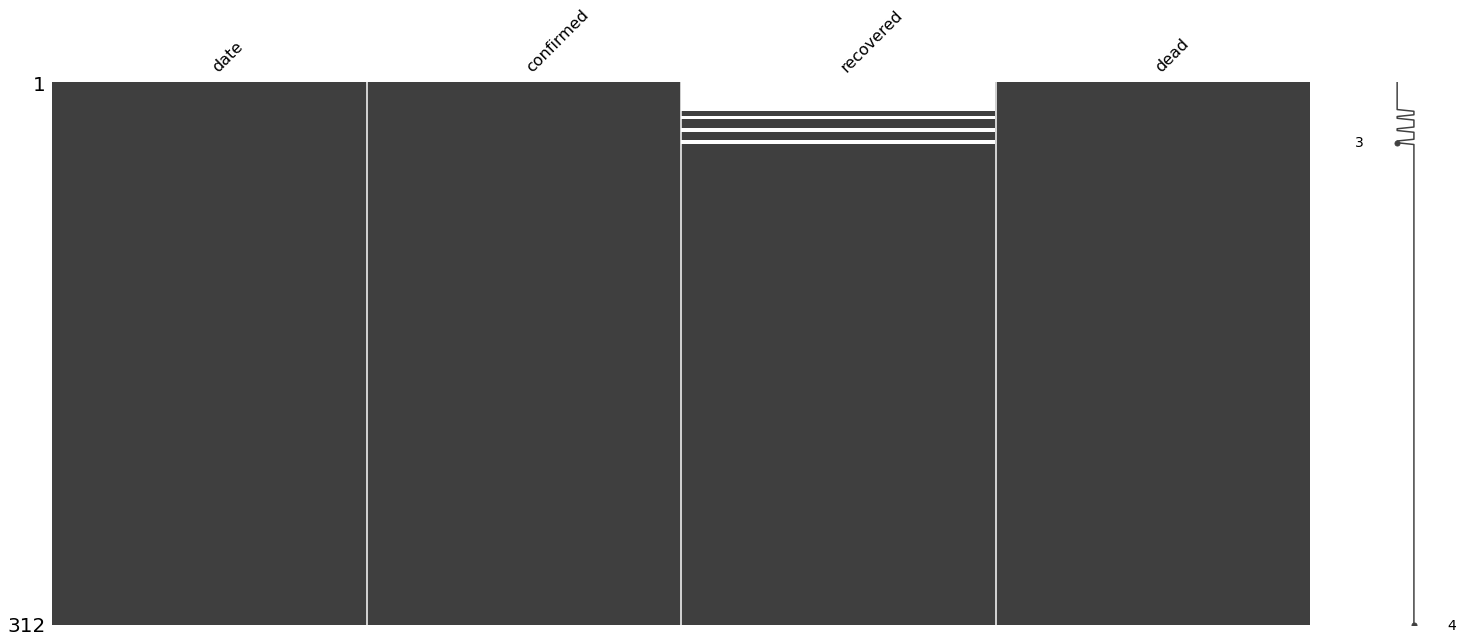

In [19]:
# visualize missing data
msno.matrix(ON) 

There are some missing data points in the recovery dataset. The missing data before 2/12/20 should be 0 since there was no recovery cases. The missing datapoints after that should be due to lack of record. Assuming that recovery cases don't suddenly change much, I will replace the missing datapoints with the mean of the existing datapoints of one day before or one day after.

In [20]:
# handle missing data
ON['recovered'][ON['date'] == '2/12/20'].index[0]
# replace with 0
ON.loc[:17,['recovered']] = ON.loc[:17,['recovered']].fillna(0)
# replace with the mean of previous and next datapoints
print(ON['recovered'][ON['recovered'].isna()])
ON.loc[20:22,['recovered']] = (ON.loc[19,['recovered']][0] + ON.loc[22,['recovered']][0])/2
ON.loc[27:29,['recovered']] = (ON.loc[26,['recovered']][0] + ON.loc[29,['recovered']][0])/2
ON.loc[34:36,['recovered']] = (ON.loc[33,['recovered']][0] + ON.loc[36,['recovered']][0])/2

20   NaN
21   NaN
27   NaN
28   NaN
34   NaN
35   NaN
Name: recovered, dtype: float64


<AxesSubplot:>

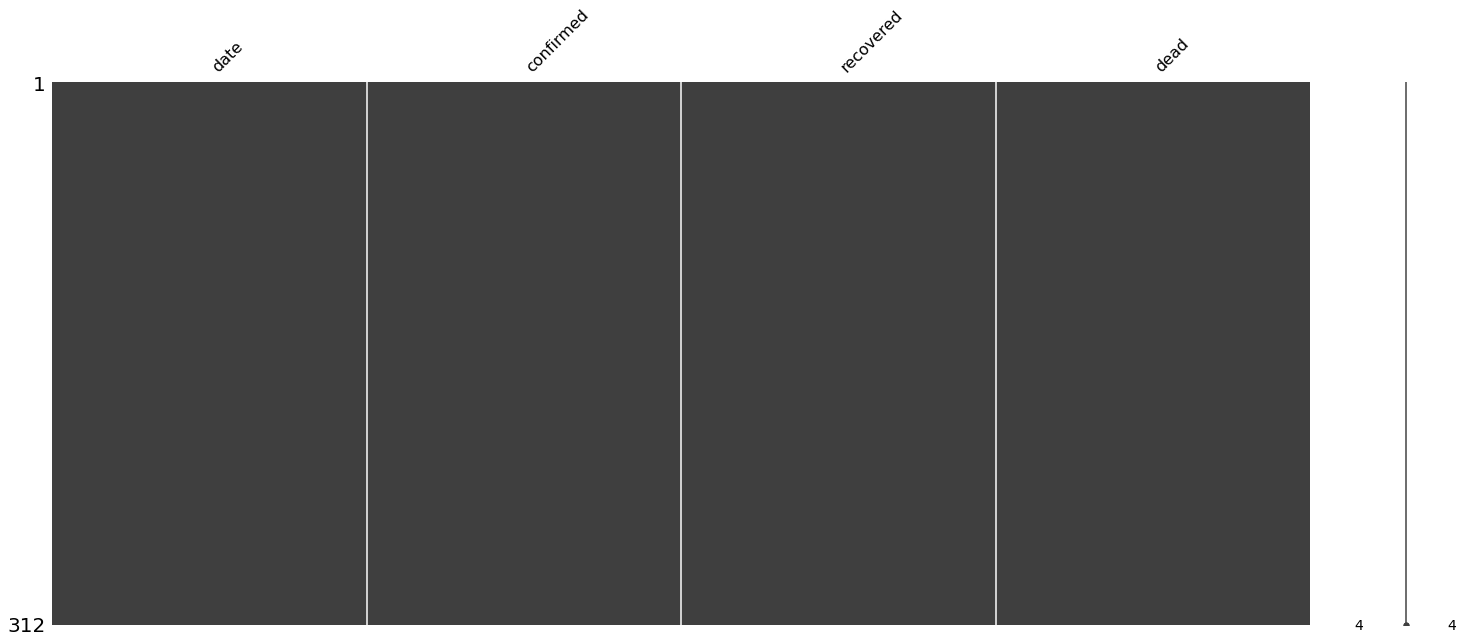

In [21]:
# check no missing data
msno.matrix(ON)

## 2. Data Visualization and Exploratory Data Analysis – [10 Marks]

Depending on how you want to conduct your analysis of COVID-19 cases **present 3 graphical figures** that visualize aspects or information in the data that you will further explore with your models. How could these trends be used to help with the task of methodically extracting all information and trends of this type? Consider how accessing the data and creating these visualizations will inform how the data will need to be preprocessed and fed into your models. All graphs should be readable and presented in the notebook. All axes must be appropriately labeled.

Text(0.5, 1.0, 'Accumulative confirmed, recovered, and dead cases in ON')

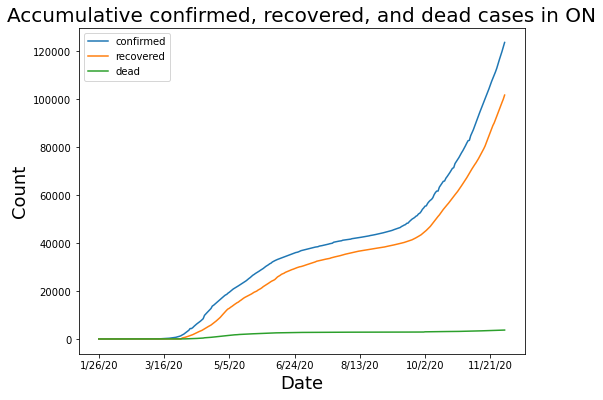

In [22]:
# look at how do infection, recovery, and death accumulate across time
ON.plot(x='date',ylabel = 'count',figsize=(8, 6))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Accumulative confirmed, recovered, and dead cases in ON', fontsize=20)

### Important policy dates

In [23]:
# https://globalnews.ca/news/6859636/ontario-coronavirus-timeline/
# https://toronto.ctvnews.ca/ontario-places-toronto-and-peel-region-under-lockdown-here-s-what-you-need-to-know-1.5197410

# first wave restrictions
stateOfEmergency = '3/17/20'
closeNonessentialBusiness = '3/23/20'
noOutdoorAmentities = '3/30/20'
closeMoreBusiness = '4/3/20'
# first wave reopens
stage1reopen = '5/19/20'
stage2reopenStart = '6/8/20'
stage2reoponToronto = '6/22/20'
stage2reoponall = '7/6/20'
stage3reoponStart = '7/17/20'
stage3reoponToronto = '7/31/20'
schoolreopen = '7/30/20'
# second wave restrictions
secondWaveStart = '9/28/20'
returnStage2 = '9/28/20'
RecreationalClosure = '10/9/20'
TorontoLockdown = '11/20/20'

Text(0.5, 1.0, 'Accumulative confirmed, recovered, and dead cases in ON')

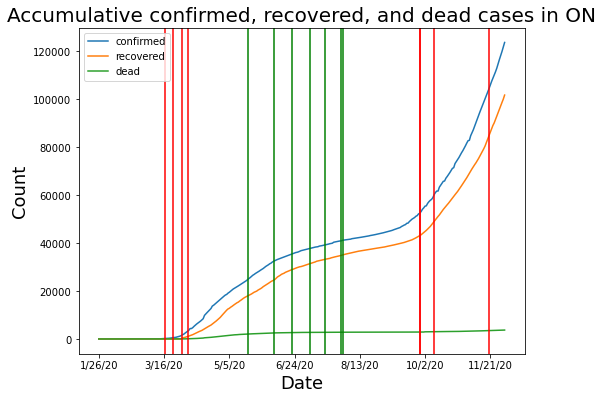

In [24]:
fig, ax = plt.subplots()
ON.plot(ax=ax,x='date',ylabel = 'count',figsize=(8, 6))
ax.axvline(ON[ON['date'] == stateOfEmergency].index[0],color="red")
ax.axvline(ON[ON['date'] == closeNonessentialBusiness].index[0],color="red")
ax.axvline(ON[ON['date'] == noOutdoorAmentities].index[0],color="red")
ax.axvline(ON[ON['date'] == closeMoreBusiness].index[0],color="red")
ax.axvline(ON[ON['date'] == stage1reopen].index[0],color="green")
ax.axvline(ON[ON['date'] == stage2reopenStart].index[0],color="green")
ax.axvline(ON[ON['date'] == stage2reoponToronto].index[0],color="green")
ax.axvline(ON[ON['date'] == stage2reoponall].index[0],color="green")
ax.axvline(ON[ON['date'] == stage3reoponStart].index[0],color="green")
ax.axvline(ON[ON['date'] == stage3reoponToronto].index[0],color="green")
ax.axvline(ON[ON['date'] == schoolreopen].index[0],color="green")
ax.axvline(ON[ON['date'] == secondWaveStart].index[0],color="red")
ax.axvline(ON[ON['date'] == returnStage2].index[0],color="red")
ax.axvline(ON[ON['date'] == RecreationalClosure].index[0],color="red")
ax.axvline(ON[ON['date'] == TorontoLockdown].index[0],color="red")

plt.xlabel('Date', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Accumulative confirmed, recovered, and dead cases in ON', fontsize=20)

### For building SIR model in the next xection, let's create the corresponding columns for S (susceptible), I (Infected = active cases), R (removed) in ON data and have a look at them.

In [25]:
# Ontario population is estimated to be around 14.73 million
# https://www.statista.com/statistics/569874/population-estimates-ontario-canada/
# total population = N
N = 14730000

In [26]:
# compute the susceptible and removed columns
ON['susceptible'] = ""
ON['removed'] = ""
ON['infected'] = ""
for i in range(len(ON)):
    # accumulative confirmed cases includes those that tranferred to removed. S = total pop - confirmed
    ON.loc[i,'susceptible'] = (N - ON.loc[i,'confirmed']) 
    ON.loc[i,'removed'] = (ON.loc[i,'recovered'] + ON.loc[i,'dead'])
    ON.loc[i,'infected'] = (ON.loc[i,'confirmed'] - ON.loc[i,'removed'])

In [27]:
# only take columns for date,S,I,R
ON = ON.loc[:,['date','susceptible','infected','removed']]

# rename columns to make them distinguishable from SIR model date built later
ON.columns = ['date','susceptible_real','infected_real','removed_real']
ON.head(3)

,date,susceptible_real,infected_real,removed_real
0,1/26/20,14729999,1,0
1,1/27/20,14729999,1,0
2,1/28/20,14729999,1,0


Text(0.5, 1.0, 'Accumulative S, I, R in ON')

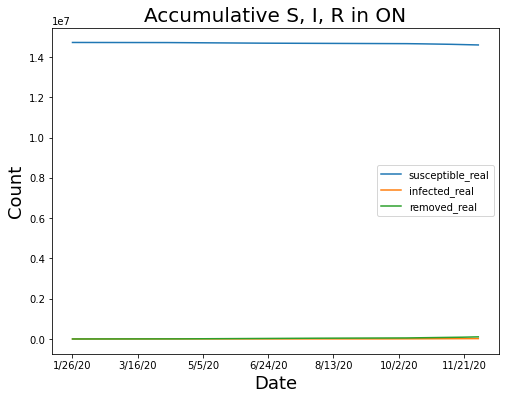

In [28]:
# look at how do infection, recovery, and death accumulate across time
ON.plot(x='date',ylabel = 'count',figsize=(8, 6))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Accumulative S, I, R in ON', fontsize=20)

A large number of population in ON are in the susceptible state. Let's look at only the infected and removed cases.

Text(0.5, 1.0, 'Accumulative I & R in ON')

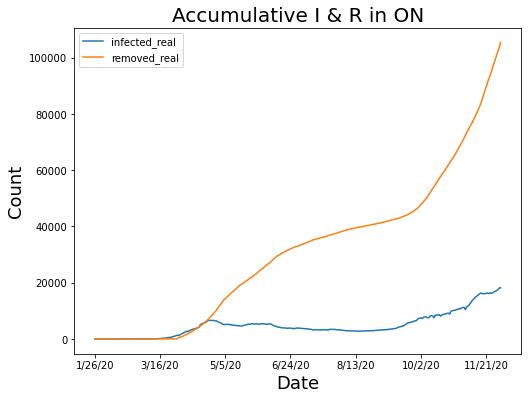

In [29]:
# look at only the infected and removed cases
ON.loc[:,['date','infected_real','removed_real']].plot(x='date',ylabel = 'count',figsize=(8, 6))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Accumulative I & R in ON', fontsize=20)

The majority of the confirmed cases recovered with few still active cases (infected).

## 3. Model selection and fitting to data – [35 Marks]

Select a model of your choice (for example you may select an SIR Model, ARIMA, optimization or MC simulation modelling or any of the other models we have covered) that will allow you to **project the time series of COVID-19 Cases into the future**. 

You should output **three projections, one that assumes worst case spread, another that assumes best case spread and a third that models a base-case in between best and worst spread**. You must justify your algorithm choices and the approach you will use to generate the 3 cases of projections. 

You may also choose to study multiple models and report on the suitability of each in developing projections for COVID-19. You should also use the dataset provided to **fit/train model(s) selected and discuss and interpret the findings of these model(s)**. You may also use this section to improve the model depending on the findings of your model(s) and how you interpret them.

### Susceptible-Infected-Removed (SIR) Model

The population of Ontario will be categorized into Susceptible, Infected (active cases), or Removed (recovered/died). 

I will use differential equations to calculated the population chage over time.

    N: total population
    S(t): number of people susceptible on day t
    I(t): number of people infected on day t
    R(t): number of people recovered or died on day t
    β: expected amount of people an infected person infects per day
    D: number of days an infected person has and can spread the disease
    γ: the proportion of infected recovering per day (γ = 1/D)
    R₀: the total number of people an infected person infects (R₀ = β / γ or β x D)


### In the following section, 

#### 1. Define functions needed for training and predicting SIR models
#### 2. Train on the 1st wave data and predict into 2nd wave period + discussion on the interpretation of the model
#### 3. Train on the 2nd wave data and predict into the unknown future + discussion on the interpretation of the model
#### 4. Three projections into the future (base-case, worst-case, and best-case scenarios) + discussion

### 1. Define functions needed for training and predicting SIR models

In [30]:
from scipy.integrate import odeint

# The SIR model differential equations.
def deriv(state, t, N, beta, gamma):
    """
    This function solves the ordinal differential equations for S,I,R over time.
    Derivitives of S,I,R are specified as the following.
    """
    S, I, R = state
    # Change in S population over time
    dSdt = -beta * S * I / N
    # Change in I population over time
    dIdt = beta * S * I / N - gamma * I
    # Change in R population over time
    dRdt = gamma * I

    return dSdt, dIdt, dRdt

In [31]:
def train_pred_1stWave_SIR(train_data,full_data,total_pop,removed,infected,susceptible):
    """
    This function loops through different combinations of the hyperparameters (D and R0) of an SIR model.
    (gamma = 1/D; beta = R0*gamma)
    Then, it calculates the mean squred error (MSE) of the fitted S,I,R with the real S,I,R data.
    The hyperparameters and the SIR model with the lowest MSE printed and graphed.
    
    Based on the estimated parameters fitted to the 1st wave training data, 
    the SIR model predicts into the future (unseen data during second wave) 
    """
    days = range(len(train_data))
    days_future = range(len(full_data))
    
    error0 = 1e100 # set high error to be replaced
    
    for D in range(1,30):
        for R0 in np.arange(0.1,10,0.1):
            gamma = 1/D
            beta = R0*gamma

            # Use differential equations magic with our population
            ret = odeint(deriv,
                         [susceptible, infected, removed],
                         days,
                         args=(total_pop, beta, gamma))
            S, I, R = ret.T

            # Build a dataframe
            df = pd.DataFrame({
                'susceptible': S,
                'infected': I,
                'removed': R,
                'day': days
            })
        
            # compute Mean Squred Error between computed and real S,I,R data across the training timepoints
            MSE = (np.mean((train_data['susceptible_real'] - df['susceptible'])**2) + np.mean((train_data['infected_real'] - df['infected'])**2) + np.mean((train_data['removed_real'] - df['removed'])**2))/3
        
            if MSE < error0:
                best_fit = df
                best_paras = [D,gamma,beta,R0]
                error0 = MSE
    
    beta = best_paras[2]
    gamma = best_paras[1]

    # print the best parameters
    print("Best hyperparameters: \nD:",best_paras[0],
      "\ngamma:",best_paras[1],
      "\nbeta:",best_paras[2],
      "\nR0:",best_paras[3])
    
    # plot SIR model
    plt.style.use('ggplot')
    fig, ax = plt.subplots()
    best_fit.plot(ax=ax,
                  x='day',
                  y=['infected', 'susceptible', 'removed'],
                    color=['#bb6424', '#aac6ca', '#cc8ac0'],
                    kind='area',
                    stacked=True,
                    alpha = 0.7)
    ax.set_facecolor('white')
    ax.grid(True, color='lightgrey')
    plt.xlabel('Day', fontsize=18)
    plt.ylabel('Count', fontsize=18)
    plt.title('(1) SIR model trained on May-September', fontsize=20,pad=20)
    plt.show()
    
    # rename the SIR model columns
    best_fit.columns = ['susceptible_SIR','infected_SIR','removed_SIR','day']
    
    # plot only I & R
    fig, ax = plt.subplots()
    pd.concat((train_data.loc[:,['date','infected_real','removed_real']],best_fit.loc[:,['infected_SIR','removed_SIR']]),axis=1).plot(ax=ax,x='date',ylabel='Number of cases',color = ['red','orange','blue','darkblue'],figsize=(8, 6))
    ax.set_facecolor('white')
    ax.grid(True, color='lightgrey')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Number of cases', fontsize=18)
    plt.title('(2) I & R trained on May-September', fontsize=20,pad=20)
    plt.show()
    
    
    ##### use the trained SIR model to predict future data #####
    # solve differential equations
    ret = odeint(deriv,
                 [susceptible, infected, removed],
                 days_future, # change the prediction length
                 args=(total_pop, beta, gamma))
    S, I, R = ret.T

    # Build a dataframe
    df = pd.DataFrame({
        'susceptible': S,
        'infected': I,
        'removed': R,
        'day': days_future
            })

    
    df.columns = ['susceptible_SIR','infected_SIR','removed_SIR','day']
    fig, ax = plt.subplots()
    pd.concat((full_data.loc[:,['date','infected_real','removed_real']],df.loc[:,['infected_SIR','removed_SIR']]),axis=1).plot(ax=ax,x='date',ylabel='Number of cases',color = ['red','orange','blue','darkblue'],figsize=(8, 6))
    ax.set_facecolor('white')
    ax.grid(True, color='lightgrey')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Number of cases', fontsize=18)
    plt.title('(3) I & R trained on May-September,\nprediction of September-December', fontsize=18,pad=20)
    plt.show()
    


In [32]:
def train_pred_2ndWave_SIR(total_pop,removed,infected,susceptible,days,days_future):
    """
    This function loops through different combinations of the hyperparameters (D and R0) of an SIR model.
    (gamma = 1/D; beta = R0*gamma)
    Then, it calculates the mean squred error (MSE) of the fitted S,I,R with the real S,I,R data.
    The hyperparameters and the SIR model with the lowest MSE printed and graphed.
    
    Based on the estimated parameters fitted to the 2nd wave data, 
    the SIR model predicts into the future (unseen; unknow future) 
    """
    
    error0 = 1e100 # set high error to be replaced
    
    for D in range(1,30):
        for R0 in np.arange(0.1,10,0.1):
            gamma = 1/D
            beta = R0*gamma

            # Use differential equations magic with our population
            ret = odeint(deriv,
                         [susceptible, infected, removed],
                         days,
                         args=(total_pop, beta, gamma))
            S, I, R = ret.T

            # Build a dataframe
            df = pd.DataFrame({
                'susceptible': S,
                'infected': I,
                'removed': R,
                'day': days
            })
        
            # compute Mean Squred Error between computed and real S,I,R data across the training timepoints
            MSE = (np.mean((ON_train2['susceptible_real'] - df['susceptible'])**2) + np.mean((ON_train2['infected_real'] - df['infected'])**2) + np.mean((ON_train2['removed_real'] - df['removed'])**2))/3
        
            if MSE < error0:
                best_fit = df
                best_paras = [D,gamma,beta,R0]
                error0 = MSE
    
    beta = best_paras[2]
    gamma = best_paras[1]

    # print the best parameters
    print("Best hyperparameters: \nD:",best_paras[0],
      "\ngamma:",best_paras[1],
      "\nbeta:",best_paras[2],
      "\nR0:",best_paras[3])
    
    # plot SIR model
    plt.style.use('ggplot')
    fig, ax = plt.subplots()
    best_fit.plot(ax=ax,
                  x='day',
                  y=['infected', 'susceptible', 'removed'],
                    color=['#bb6424', '#aac6ca', '#cc8ac0'],
                    kind='area',
                    stacked=True,
                    alpha = 0.7)
    ax.set_facecolor('white')
    ax.grid(True, color='lightgrey')
    plt.xlabel('Day', fontsize=18)
    plt.ylabel('Count', fontsize=18)
    plt.title('(1) SIR model trained on Sep.-Dec.', fontsize=20,pad=20)
    plt.show()
    
    # rename the SIR model columns
    best_fit.columns = ['susceptible_SIR','infected_SIR','removed_SIR','day']
    
    # plot only I & R
    fig, ax = plt.subplots()
    pd.concat((ON_train2.loc[:,['date','infected_real','removed_real']],best_fit.loc[:,['infected_SIR','removed_SIR']]),axis=1).plot(ax=ax,x='date',ylabel='Number of cases',color = ['red','orange','blue','darkblue'],figsize=(8, 6))
    ax.set_facecolor('white')
    ax.grid(True, color='lightgrey')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Number of cases', fontsize=18)
    plt.title('(2) I & R trained on Sep.-Dec.', fontsize=20,pad=20)
    plt.show()
    
    
    ##### use the trained SIR model to predict future data #####
    
    # generate all the dates into the predicted future
    start_date = datetime.date(2020, 9, 28)
    number_of_days = 216

    date_list = []
    for day in range(number_of_days):
        a_date = (start_date + datetime.timedelta(days = day)).isoformat()
        a_date = datetime.datetime.strptime(str(a_date), '%Y-%m-%d').strftime('%-m/%-d/%y')
        date_list.append(a_date)

    
    # solve differential equations
    ret = odeint(deriv,
                 [susceptible, infected, removed],
                 days_future, # change the prediction length
                 args=(total_pop, beta, gamma))
    S, I, R = ret.T

    # Build a dataframe
    df = pd.DataFrame({
        'susceptible': S,
        'infected': I,
        'removed': R,
        'day': date_list
            })

    
    df.columns = ['susceptible_SIR','infected_SIR','removed_SIR','day']
    fig, ax = plt.subplots()
    pd.concat((ON_train2.loc[:,['infected_real','removed_real']].reset_index(drop=True),df.loc[:,['infected_SIR','removed_SIR','day']]),axis=1).plot(ax=ax,x='day',ylabel='Number of cases',color = ['red','orange','blue','darkblue'],figsize=(8, 6))
    ax.set_facecolor('white')
    ax.grid(True, color='lightgrey')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Number of cases', fontsize=18)
    plt.title('(3) I & R trained on Sep.-Dec.,\nprediction of Dec.,2020-Apr.,2021', fontsize=20,pad=20)
    plt.show()
    


### 2. Train on the 1st wave data and predict into 2nd wave period 
###    + discussion on the interpretation of the model

In [33]:
# I want to fit data starting from 5/19/20 to 9/28/20
print("5/1/20 index is",ON[ON['date'] == '5/1/20'].index[0])
print("9/28/20 index is",ON[ON['date'] == secondWaveStart].index[0])

5/1/20 index is 96
9/28/20 index is 246


In [34]:
ON_train = ON.iloc[96:246].reset_index(drop=True)
ON_train.head(3)

,date,susceptible_real,infected_real,removed_real
0,5/1/20,14712120,5790,12090
1,5/2/20,14711679,5639,12682
2,5/3/20,14711426,5243,13331


Best hyperparameters: 
D: 15 
gamma: 0.06666666666666667 
beta: 0.06 
R0: 0.9


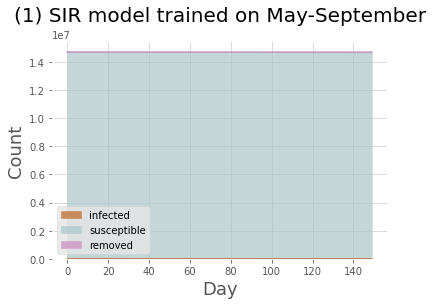

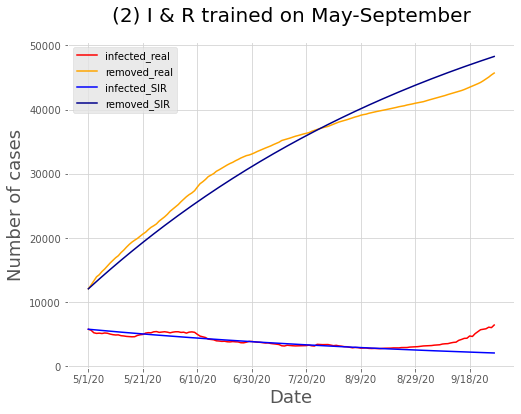

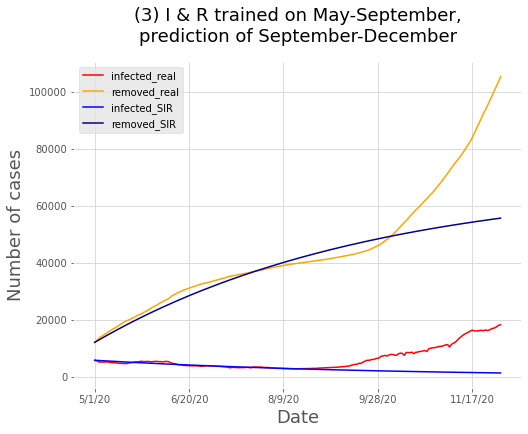

In [35]:
train_data = ON_train
full_data = ON[96:].reset_index(drop=True)

total_pop = N
removed = train_data.loc[0,'removed_real']
infected = train_data.loc[0,'infected_real']
susceptible = train_data.loc[0,'susceptible_real']

# train SIR model and predict
train_pred_1stWave_SIR(train_data,
               full_data,
               total_pop,
               removed,
               infected,
               susceptible)

#### (1) SIR model trained on May-September

The first graph plotted the complete SIR model trained on May-September data. Since a larget number of the population were still in the S (susceptible) state. Let's zoom in to look at the I (infected) and R (removed) trajectories.

#### (2) I & R trained on May-September

By fitting an SIR model to the first wave data of Ontario (May to September), we were able to know that the basic reproduction rate (R0) during the first wave was around 0.9, which is lower than the threshold of an epidemic outbreak (b0 > 1). 

R0 is the basic reproduction number for the disease indexing how many people can one infected person infects. When R0 < 1, there is no outbreak of the disease. The number of infected population will decrease and diminish. When R0 > 1, there is a disease outbreak in the population. The higher the number of R0 is, the faster the disease spread.

As we can see, the COVID19 curve was rather successfully flattened during the first wave. The effect of flattening can most likely be contributed to the restrictions imposted early in March and April.

Assuming the curve flattening effect persists, let's see how would the SIR model predict COVID19 projection from the end of September to December.

#### (3) I & R trained on May-September, prediction of September-December

As we can easily see, the model trained on the first wave data does not fit to what actually happened from September to December. The SIR model is showing how the trajectory could look like if all restrictions employed before the first wave persisted for longer.

However, the reality was that Ontario gradually lifted many restrictions in June and July. The effect of the reopenings in June and July is manifested as a second wave starting from the end of September. Later on in Part 4, we will explore the correlation between citizen mobility and the infection time-series to see whether the second wave can really be contributed to the increase mobility during the reopenings.

### 3. Train on the 2nd wave data and predict into the unknown future 
### + discussion on the interpretation of the model

Now, let's fit the second wave data that we have so far (late September to beginning of December) and see how it projects into the future.

In [36]:
# second wave start
print("9/28/20 index is",ON[ON['date'] == secondWaveStart].index[0])

9/28/20 index is 246


In [37]:
# take the second wave data as training data
ON_train2 = ON[246:].reset_index(drop=True)

Best hyperparameters: 
D: 12 
gamma: 0.08333333333333333 
beta: 0.1 
R0: 1.2000000000000002


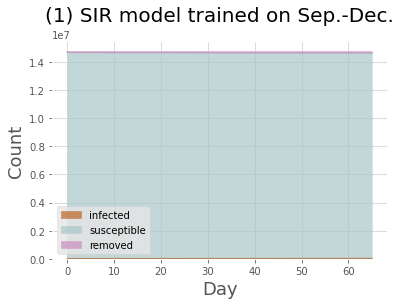

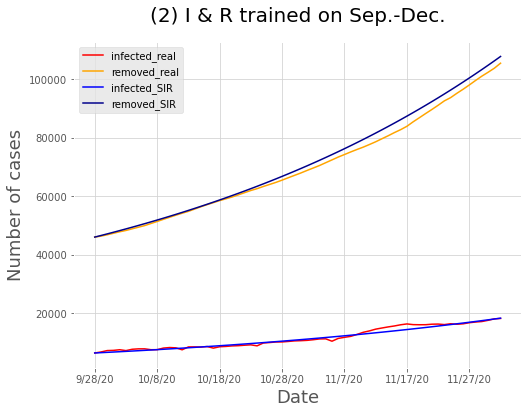

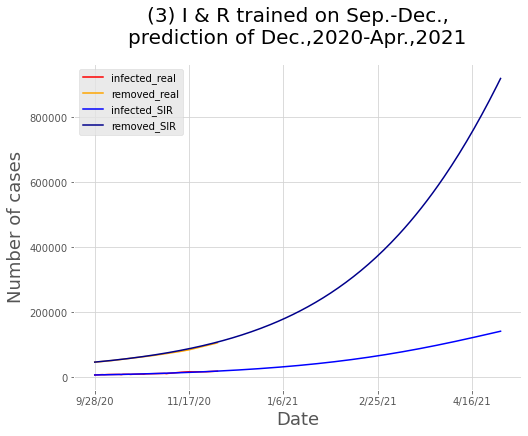

In [38]:
removed = ON_train2.loc[0,'removed_real']
infected = ON_train2.loc[0,'infected_real']
susceptible = ON_train2.loc[0,'susceptible_real']

# the days range of the training data
days = range(len(ON_train2))
# the days range of the 2nd wave training + 150 future days
days_future = range(len(ON_train2)+150)

# train SIR model to second wave and predict
train_pred_2ndWave_SIR(total_pop,
               removed,
               infected,
               susceptible,
               days,
               days_future)

#### (1) SIR model trained on September-December

The first graph plotted the complete SIR model trained on September-December data. Since a larget number of the population were/are still in the S (susceptible) state. Let's zoom in to look at the I (infected) and R (removed) trajectories.

#### (2) I & R trained on September-December

By fitting an SIR model to the second wave data that we have by far (end of September to beginning of December), we are able to know that the basic reproduction rate (R0) during the second wave is around 1.2, which has increased from the first wave (R0 = 0.9). Having a R0 > 1 indicates that we are experiencing a COVID19 outbreak that is spreading faster than before.

This second wave is likely provoked by the reopenings that happened in June and July. Still, in reaction to the start of the second wave, Ontario has restored many restrictions and lockdowns around October to November. That is to say, what we are seeing now (though it is horrifying) is not the worse possible senario. 

Let's take a look at how this base-case senario projects into the unknown future.

#### (3) I & R trained on September-December, prediction of the unknown future (base-case)

This graph shows the base-case of how the future 5 months would look like if nothing more or less is done to change the progression of COVID19. Given a R0 of 1.2, the infection cases will start to grow almost exponentially since each infected person will infect around 1.2 originally susceptible people. 

Now, let's simulate possible best and worst case senarios.

### 4. Three projections into the future (base-case, best-case, and worst-case scenarios)


In [39]:
# generate all the dates into the predicted future
start_date = datetime.date(2020, 9, 28)
number_of_days = 216

date_list = []
for day in range(number_of_days):
    a_date = (start_date + datetime.timedelta(days = day)).isoformat()
    a_date = datetime.datetime.strptime(str(a_date), '%Y-%m-%d').strftime('%-m/%-d/%y')
    date_list.append(a_date)

#### BASE case scenario for future prediction

The fitted hyperparameters can show us how the base-case senario would look like projecting into the future 5 months.

In [40]:
# base-case senario as the fitted projection
R0 = 1.2000000000000002
D = 10 
gamma = 1/D
beta = R0*gamma

# Use differential equations magic with our population
ret = odeint(deriv,
             [susceptible, infected, removed],
             days_future,
             args=(total_pop, beta, gamma))
S, I, R = ret.T

# Build a dataframe
df_base = pd.DataFrame({
    'susceptible_base': S,
    'infected_base': I,
    'removed_base': R,
    'day': date_list
    })
        

#### BEST case scenario for future prediction

Under the senario where virus reproduction rate goes lower than 1, maybe due to well-implemented social distancing and stay-at-home policies. We should see a curve flattening akin to what we saw for the first wave.

As we saw from the first wave, by implementing strict restrictions in the beginning of a wave,it's possible to successfully flatten the curve by lowering R0 to below 1. Let's change the R0 to 0.9 for the forcasing of the second wave and see how the best case senario would look like projecting into the future 5 months.

In [41]:
R0 = 0.9  # assumns reproduction rate as the first wave
D = 10
gamma = 1/D
beta = R0*gamma

# Use differential equations magic with our population
ret = odeint(deriv,
             [susceptible, infected, removed],
             days_future,
             args=(total_pop, beta, gamma))
S, I, R = ret.T

# Build a dataframe
df_best = pd.DataFrame({
    'susceptible_best': S,
    'infected_best': I,
    'removed_best': R,
    'day': date_list
            })
        

#### WORST case scenario for future prediction

As we discussed earlier, the current case senario is the base-case since the situation could be worst if the government didn't restore restrictions in October and November or if the government decides to lift the restriction during the second wave. 

One possible way to simulate the worst case is to increase the reproduction rate (R0) to higher than what we have right now (R0 = 1.2).

In [42]:
R0 = 1.4 # assumes reproduction rate worse than the fitted rate
D = 10
gamma = 1/D
beta = R0*gamma

# Use differential equations magic with our population
ret = odeint(deriv,
             [susceptible, infected, removed],
             days_future,
             args=(total_pop, beta, gamma))
S, I, R = ret.T

# Build a dataframe
df_worst = pd.DataFrame({
    'susceptible_worst': S,
    'infected_worst': I,
    'removed_worst': R,
    'day': date_list
            })

In [43]:
# combine all senario data
df_preds = pd.concat((df_worst, df_base, df_best),axis = 1)

In [44]:
df_preds = df_preds.loc[:,~df_preds.columns.duplicated()]
df_preds.head(3)

,susceptible_worst,infected_worst,removed_worst,day,susceptible_base,infected_base,removed_base,susceptible_best,infected_best,removed_best
0,1.467755e+07,6433.000000,46016.000000,9/28/20,1.467755e+07,6433.000000,46016.000000,1.467755e+07,6433.000000,46016.000000
1,1.467664e+07,6692.169864,46672.173528,9/29/20,1.467677e+07,6560.130897,46665.636188,1.467698e+07,6366.938638,46655.992149
2,1.467568e+07,6961.719347,47354.779849,9/30/20,1.467598e+07,6689.731372,47328.108182,1.467641e+07,6301.533861,47289.409114


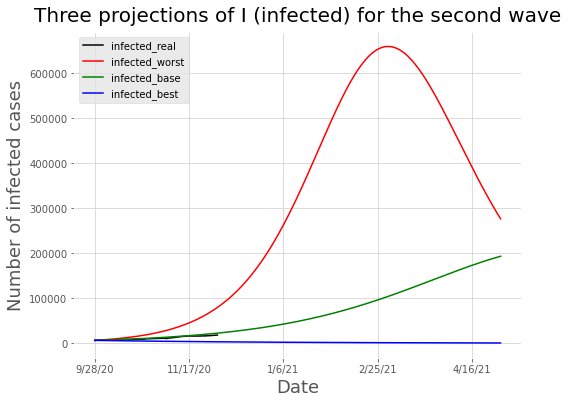

In [45]:
# plot the three projections of infected cases
fig, ax = plt.subplots()
pd.concat((ON_train2.loc[:,['infected_real']],df_preds.loc[:,['day','infected_worst','infected_base','infected_best']]),axis=1).plot(ax=ax,x='day', ylabel="Number of infected cases", color = ['black','red','green','blue'],figsize=(8, 6)) 
ax.set_facecolor('white')
ax.grid(True, color='lightgrey')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of infected cases', fontsize=18)
plt.title('Three projections of I (infected) for the second wave',fontsize=20,pad=10)
plt.show()

As we can see, starting from September 28th, 2020, there could be three different projections for the infected cases.

If we were to handle COVID19 as well as we did initially for the first wave (flattening the curve and decrease R0 to 0.9), we could have gotten the blue line projection where the infected cases gradually decrease. 

However, we have reopened the province too quickly, resulting in a second wave that is worse than the first wave since the second wave started with a larget number of infected people. As the result, the base-case that we are experiencing now is the green line projection. 

The base-case senario is bad (R0 = 1.2) but not as bad as how it could be if the government were to do nothing in reaction to the start of the second wave. The red line projection warns us how bad it could be if the reopenings persisted longer into the second wave or if no restrictions were re-imposed onto regions in Ontario. This kind of trajectory is very dangerous since it will overload the medical resources, resulting in a large number of the population infected and not receiving treatments.

## 4. Relating COVID-19 Projections to a Second Dataset [25 Marks]

Select another dataset of your choice. In this part of the project you will **use your 2nd chosen dataset to examine and analyze a factor that is related to COVID-19**.

Extending from what we saw from Part 3, we can investigate whether citizen mobility is correlated with the infected cases flunctuations from the first to the second wave. We've been assuming that the reopening during May and June is driving the sceond wave. Now we can see whether the data actually support this argument. 

Disclaimer: No actual causality is established between datasets. The strength of correlation can inform the possibility of a causal relationship but not establish one. We are exploring the strength of (time-lagged) correlation between mobility and the number of infected population. 

In [46]:
# read the mobility data from Apple
Mob = pd.read_csv("applemobilitytrends-2020-12-04.csv",low_memory = False)

In [47]:
Mob.head()

,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2020-11-25,2020-11-26,2020-11-27,2020-11-28,2020-11-29,2020-11-30,2020-12-01,2020-12-02,2020-12-03,2020-12-04
0,country/region,Albania,driving,NaN,NaN,NaN,100.0,95.30,101.43,97.20,...,94.64,91.62,108.34,124.73,120.86,105.74,97.80,94.97,96.89,104.39
1,country/region,Albania,walking,NaN,NaN,NaN,100.0,100.68,98.93,98.46,...,122.56,118.68,134.67,135.69,118.89,126.35,123.88,126.48,106.48,130.41
2,country/region,Argentina,driving,NaN,NaN,NaN,100.0,97.07,102.45,111.21,...,63.91,72.30,91.13,87.69,55.07,65.72,70.89,72.47,84.38,107.65
3,country/region,Argentina,walking,NaN,NaN,NaN,100.0,95.11,101.37,112.67,...,53.32,59.24,71.76,60.96,37.25,54.21,61.57,58.88,68.62,81.35
4,country/region,Australia,driving,AU,NaN,NaN,100.0,102.98,104.21,108.63,...,107.94,117.86,114.10,92.44,98.94,100.90,105.52,108.80,120.13,116.43


In [48]:
# only take data in Ontario
ON_mob = Mob[Mob['region'] == 'Ontario']
ON_mob = ON_mob.iloc[:,2:].drop(['alternative_name','sub-region','country'],axis=1).reset_index(drop=True)

In [49]:
ON_mob = ON_mob.set_index('transportation_type').T

In [50]:
# only take data till Dec. 2nd
ON_mob = ON_mob[13:-2]

In [51]:
# change date formate
dates_new = []
for i in ON_mob.index.values:
    new = datetime.datetime.strptime(str(i), '%Y-%m-%d').strftime('%-m/%-d/%y') # have "-" before m to remove the leading 0
    dates_new.append(new)

In [52]:
# put date in dataframe format
dates_new = pd.DataFrame(dates_new)
# combine new date formate to mobility dataset and set as index
ON_mob = pd.concat((dates_new,ON_mob.reset_index()),axis = 1)
ON_mob.columns = ['date','index','driving','walking','transit']
ON_mob = ON_mob.drop('index',axis=1)

In [53]:
ON_mob.head(3)

,date,driving,walking,transit
0,1/26/20,84.13,80.89,71.16
1,1/27/20,94.99,95.01,90.57
2,1/28/20,100.35,104.09,94.03


Text(0.5, 1.0, 'Mobility changes with important policy dates')

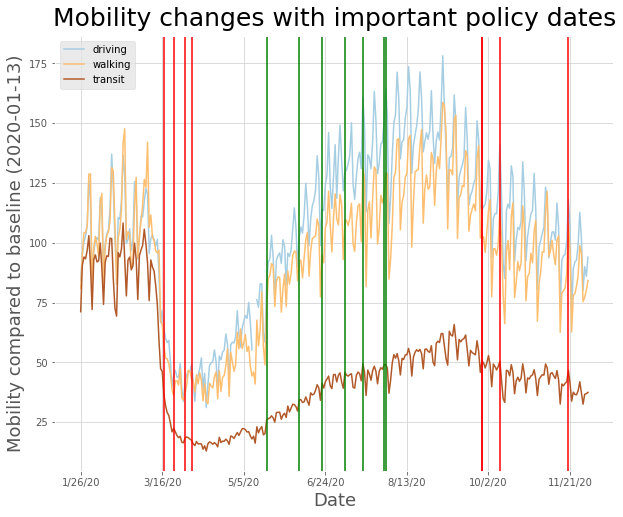

In [54]:
# add lines for the dates of important policies
fig, ax = plt.subplots()
ON_mob.plot(ax=ax,x='date',ylabel='Mobility compared to baseline (2020-01-13)',figsize=(10, 8),cmap = 'Paired')
ax.axvline(ON_mob[ON_mob['date'] == stateOfEmergency].index[0],color="red")
ax.axvline(ON_mob[ON_mob['date'] == closeNonessentialBusiness].index[0],color="red")
ax.axvline(ON_mob[ON_mob['date'] == noOutdoorAmentities].index[0],color="red")
ax.axvline(ON_mob[ON_mob['date'] == closeMoreBusiness].index[0],color="red")
ax.axvline(ON_mob[ON_mob['date'] == stage1reopen].index[0],color="green")
ax.axvline(ON_mob[ON_mob['date'] == stage2reopenStart].index[0],color="green")
ax.axvline(ON_mob[ON_mob['date'] == stage2reoponToronto].index[0],color="green")
ax.axvline(ON_mob[ON_mob['date'] == stage2reoponall].index[0],color="green")
ax.axvline(ON_mob[ON_mob['date'] == stage3reoponStart].index[0],color="green")
ax.axvline(ON_mob[ON_mob['date'] == stage3reoponToronto].index[0],color="green")
ax.axvline(ON_mob[ON_mob['date'] == schoolreopen].index[0],color="green")
ax.axvline(ON_mob[ON_mob['date'] == secondWaveStart].index[0],color="red")
ax.axvline(ON_mob[ON_mob['date'] == returnStage2].index[0],color="red")
ax.axvline(ON_mob[ON_mob['date'] == RecreationalClosure].index[0],color="red")
ax.axvline(ON_mob[ON_mob['date'] == TorontoLockdown].index[0],color="red")
ax.set_facecolor('white')
ax.grid(True, color='lightgrey')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mobility compared to baseline (2020-01-13)', fontsize=18)
plt.title('Mobility changes with important policy dates', fontsize=25,pad=10)

In this graph, we can see that Ontario citizen mobility is influenced by the policies announced by the government. Right after the initial announcement of the state of emergency, the mobility dropped drastially. Then, the driving and walking mobility gradually increased back to baseline during May-June and even surpassed the baseline during June to September. The increase of mobility corresponds to the reopenings (green lines). (P.S.: This is not supported by the data shown here but the nice weather during the summer was most likely a great factor as well). Then, the mobility levels dropped once again in the beginning of the second wave (but not as drastic as the first time).

Let's see if we can observe similar pattern in the infected cases cross time.

In [55]:
ON = ON.fillna(0)
ON = ON.reset_index()

Text(0.5, 1.0, 'Accumulated infected cases over time\nwith important policy dates')

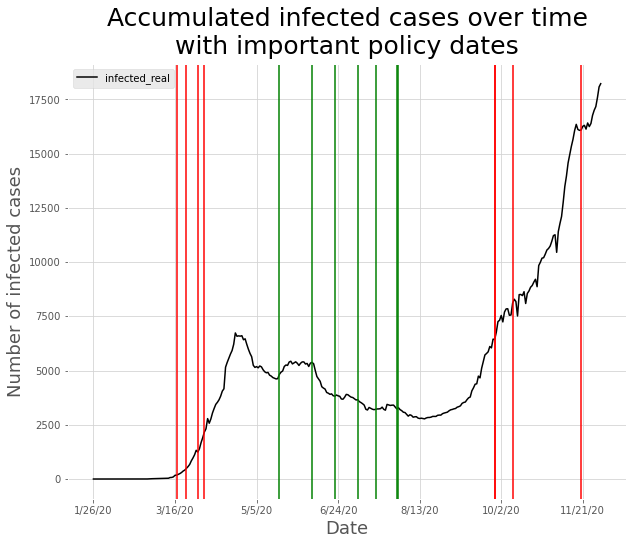

In [56]:
# add lines for the dates of important policies
fig, ax = plt.subplots()
ON.loc[:,['date','infected_real']].plot(ax=ax,x='date',figsize=(10, 8),color='black')
ax.axvline(ON[ON['date'] == stateOfEmergency].index[0],color="red")
ax.axvline(ON[ON['date'] == closeNonessentialBusiness].index[0],color="red")
ax.axvline(ON[ON['date'] == noOutdoorAmentities].index[0],color="red")
ax.axvline(ON[ON['date'] == closeMoreBusiness].index[0],color="red")
ax.axvline(ON[ON['date'] == stage1reopen].index[0],color="green")
ax.axvline(ON[ON['date'] == stage2reopenStart].index[0],color="green")
ax.axvline(ON[ON['date'] == stage2reoponToronto].index[0],color="green")
ax.axvline(ON[ON['date'] == stage2reoponall].index[0],color="green")
ax.axvline(ON[ON['date'] == stage3reoponStart].index[0],color="green")
ax.axvline(ON[ON['date'] == stage3reoponToronto].index[0],color="green")
ax.axvline(ON[ON['date'] == schoolreopen].index[0],color="green")
ax.axvline(ON[ON['date'] == secondWaveStart].index[0],color="red")
ax.axvline(ON[ON['date'] == returnStage2].index[0],color="red")
ax.axvline(ON[ON['date'] == RecreationalClosure].index[0],color="red")
ax.axvline(ON[ON['date'] == TorontoLockdown].index[0],color="red")
ax.set_facecolor('white')
ax.grid(True, color='lightgrey')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of infected cases', fontsize=18)
plt.title('Accumulated infected cases over time\nwith important policy dates', fontsize=25,pad=10)

The mobility data (all three transportation types) and the infected cases both exhibit a trend of decrease and then increase. However, there seems to be a time-lag of the matching trend between the two datasets (remember how we already saw the second decrease in mobility but not yet in infected case data). This is very realistic since decreased mobility (increased social distancing) usually takes time to reflect its effect on COVID19 mitigation in real life. 

We can do a cross-correlation to find out what is the time-lag that gives the highest correlation between the infection data and the mobility data and how significant are the correlations.

In [57]:
# change to float type for correlation
ON = ON.set_index('date')
ON = ON.astype(float)

In [58]:
# check for missing data
print(ON_mob[ON_mob['driving'].isna()])
#ON_mob[ON_mob['walking'].isna()]
#ON_mob[ON_mob['transit'].isna()]

# replace missing data with the mean of the previous and next datapoints
ON_mob.loc[106,['driving']] = (ON_mob.loc[105,['driving']] + ON_mob.loc[108,['driving']])/2
ON_mob.loc[107,['driving']] = (ON_mob.loc[105,['driving']] + ON_mob.loc[108,['driving']])/2

# check no missing data
print(ON_mob[ON_mob['driving'].isna()])

        date  driving  walking  transit
106  5/11/20      NaN    45.96    19.10
107  5/12/20      NaN    40.91    16.16
Empty DataFrame
Columns: [date, driving, walking, transit]
Index: []


In [59]:
import scipy.stats

### define functions to calculate and plot cross-correlations ###

def crosscorr(datax, datay, lag=0, wrap=False):
    """ 
    Lag-N cross correlation. 
    Shifted data filled with 0 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float (pearson's r, p-value)
    """
    return scipy.stats.pearsonr(datax, datay.shift(lag).fillna(0))


def plot_xcorr(mob_type, lags):
    """
    This function use the crosscorr function to calculate time-lagged correlation between two datasets.
    Plots the cross-correlations and lable the peak r value and p-value.
    """
    df1 = ON['infected_real']
    df2 = ON_mob[mob_type]
    
    rs = [crosscorr(df1,df2, lag)[0] for lag in range(-int(lags),int(lags+1))] # record pearson's r for each lag
    ps = [crosscorr(df1,df2, lag)[1] for lag in range(-int(lags),int(lags+1))] # record p-value for each r
    
    f,ax=plt.subplots(figsize=(10,5))
    ax.plot(rs,color='blue')
    ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
    ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
    #ax.set(title=f'Cross-correlation between {mob_type} mobility and number of infected cases\nInfection leads <> Mobility leads', xlabel='Lags (Days)',ylabel='Pearson r')
    ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
    ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150])
    ax.set_facecolor('white')
    ax.grid(True, color='lightgrey')
    plt.legend()
    plt.xlabel('Lags (Days)', fontsize=18)
    plt.ylabel('Pearson r', fontsize=18)
    plt.title(f'Cross-correlation between {mob_type} mobility and number of infected cases\nInfection leads <> Mobility leads', fontsize=20,pad=10)
    
    print("Peak xcorr happens at lag ",np.argmax(rs)-150,"days")
    print("Peak xcorr is {:.2f}; p-value:{:.2e}".format(rs[np.argmax(rs)],ps[np.argmax(rs)]))

Peak xcorr happens at lag  88 days
Peak xcorr is 0.79; p-value:4.78e-67
Peak xcorr happens at lag  81 days
Peak xcorr is 0.78; p-value:2.29e-64
Peak xcorr happens at lag  81 days
Peak xcorr is 0.57; p-value:3.12e-28


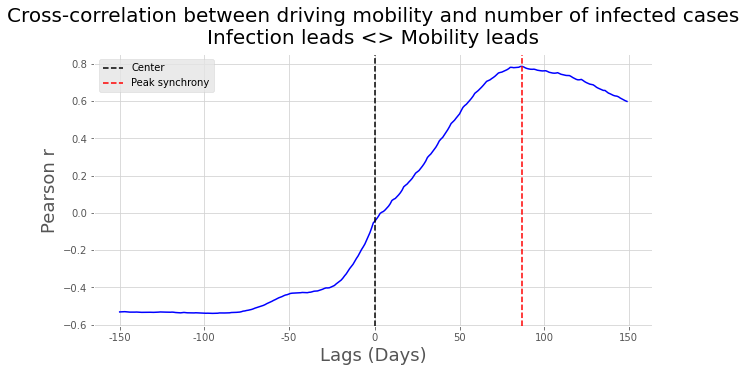

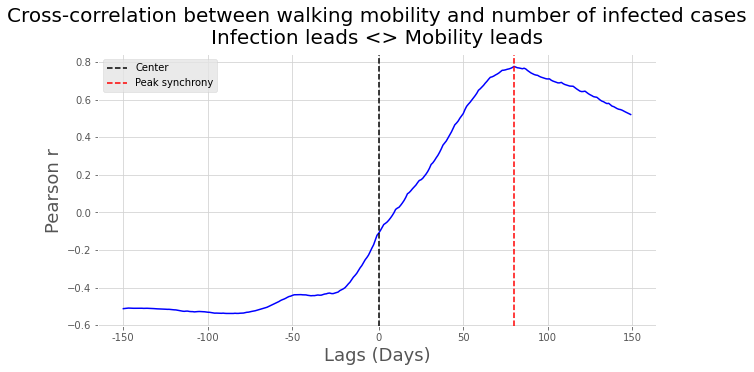

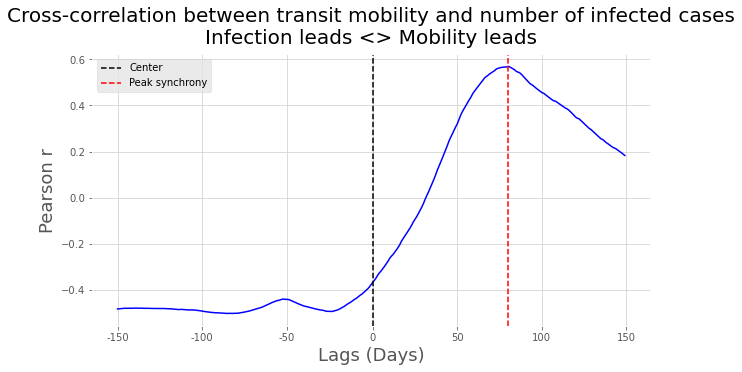

In [60]:
type_list = ['driving','walking','transit']
for i in type_list:
    plot_xcorr(i, 150)

From the cross correlations between each type of mobility and number of infected cases, we can see that the mobility changes leads infection changes (=infection data lags the mobility data) for about 81-88 days, meaning that the effect of mobility on changes to infection number usually takes about almost 3 months to show. This time-lag is a very important information to inform the policy makers and the public to be patient and wait for the restrictions to work and not to open up the province too quickly.

There are **significant positive correlations** between all three types of mobility and infection cases. 

For driving:
   - Peak cross-correlation happens at lag 88 days (correlates with infection data 88 days later)
   - Peak cross-correlation is 0.79 ; p-value: 4.74e-67
    
For walking:
   - Peak cross-correlation happens at lag 81 days (correlates with infection data 81 days later)
   - Peak cross-correlation is 0.778 ; p-value: 2.27e-64

For transit:
   - Peak cross-correlation happens at lag 81 days (correlates with infection data 81 days later)
   - Peak cross-correlation is 0.57 ; p-value: 3.11e-28

As we can see from the p-values, these are all significant correlations, indicating that citizen mobility is likely an important factor on the number of infection cases in that the more mobile people are, the more people become infected 3 months after.

Now that we know the optimal lag, let's shift the infection data 85 days (mean of 81 and 88 days) forward and see how the trend match and have a glimps at what to expect on the infection cases in the near future based on the mobility data.

Text(0.5, 1.0, 'Mobility changes with infected data shifted 85 days forward')

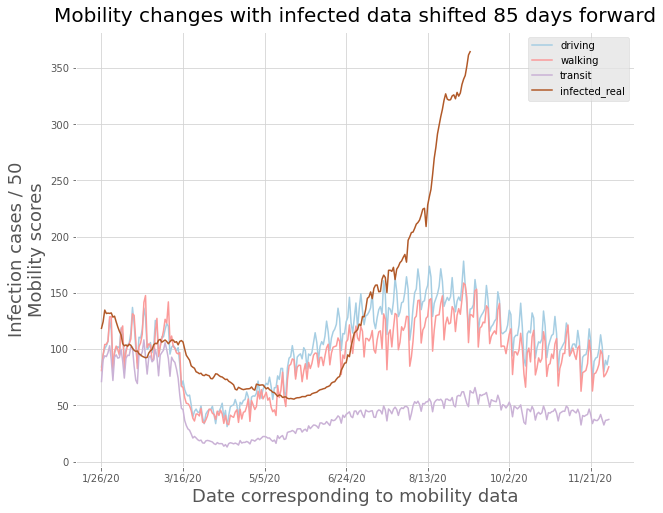

In [61]:
f,ax = plt.subplots()
pd.concat((ON_mob,(ON['infected_real']/50).reset_index(drop=True).shift(periods=-85).dropna()),axis=1).plot(ax=ax,x='date',xlabel='Date corresponding to mobility data',
                                                                                                            ylabel='Infection cases / 50\nMobility scores',figsize=(10, 8),cmap = 'Paired')
ax.set_facecolor('white')
ax.grid(True, color='lightgrey')
plt.xlabel('Date corresponding to mobility data', fontsize=18)
plt.ylabel('Infection cases / 50\nMobility scores', fontsize=18)
plt.title('Mobility changes with infected data shifted 85 days forward', fontsize=20,pad=10)
    

We can clearly see the trends shared between the mobility data and the number of infection cases. Although not perfectly matching, the two datasets share the main ups and downs. The dip in mobility during March to May corresponded with the decrease in the shifted infection time-series. The restoration of mobility corresponds to the return of infection cases in June. Then, mobility started to increase over baseline (baseline is set in January) and so did number of infected cases. Alarmingly, we can see how different the scales of the changes in mobility and infection numbers are. This is telling us that seemingly small changes in our mobility can have a profound effect on the number of infected cases.

For now, though we've seen another wave of decrease in mobility for ON citizens, the number of infected cases is still increasing. However, this doesn't mean the lockdowns and stay-at-home policies are not working. It simply means these efforts take time to play their tricks. As we've analyzed in this section, we will likely see the curve flatterning effect on a the infected cases reflecting our current lockdown efforts about 3 months later.

## 5. Deriving insights about policy and guidance to tackle the outbreak based on model findings – [25 Marks]


Some discussions have been covered in Part 3 and 4 along side the analyses.

Here I would like to organize a few main insights that we've derived from the analyses:

**1. Stay at home helps :)**
    
    Yes, all those commercials saying, "Stay at home and save lives" are truthful. Staying at home is a crucial tactic to battle this pendemic since it directly decrease human-to-human contact. This argument is supported by the significant correlation between citizen mobility and number of infected cases. Moreover, as we saw from the first wave of COVID19 in Ontario, the lockdown restrictions imposed in March paid off in May to September. We successfully flattened the curve by decreasing the reproduction rate to lower than 1 (R0 was 0.9).
    
    As we all know, it is extremely difficult to keep people at home because (but not limited to these point):
    
    (1) we are social animals  
    
    Counting on the citizens to be self-awared might not be effective enough. Fortunately, from our mobility data, we can be assured that (at least the majority of) people do follow the policies (policies have an impact on mobility scores). When lockdowns were imposed, mobility score drops. When restrictions were lifted, mobility score increases. Therefore, this obsevation stresses the importance of having restrictive policies from the governments to force the mitigation of COVID19 spread.
    
    (2) many people need to go out and work to earn money
    
    Relating to the practice of decreased mobility (staying at home), it is worth noting the importance for the government to issue policies that secure the financial needs for the citizens' basic living. Otherwise, it is simply impossible for those who cannot work from home to follow the stay-at-home commands.
    
**2. Be patient :) Don't party before we are done hammering.**
    
    Yes, staying at home works, but only if we stay for long enough. From the cross-correlation between mobility and number of infected cases, we leared that there is a time-lag between the changes in citizen mobility and changes in the number of infected cases. To be specific, the changes in mobility will reflect on the infected cases around 3 months later. This time-lag explains why we saw a decrease in infected cases around 3 months after the initial lockdown and an increase of infected cases around 3 months after the reopening. 
    
    This time-lag between policies and their effect on COVID19 cases can be both encouraging and alarming. It is encouraging since we can be more confident that even if we don't see the effect of our current lockdown yet, we can trust that it will pay off later on (see the predicted flattening effect showing up around April, 2020 in the base-case scenario). On the other hand, it is alarming because if we open up the province right when the flattening is working (which is what we did during the first wave), though it may feel like nothing is going wrong at the time, we can anticipate a thrid wave coming up 3 months after.
    
    The results of the analyses manifested the importance for the policy-makers to acknowledge the lag and take it into considerations when estimating the timing for re-opening. This leads us to the next point.
    
**3. It can be worst or better, depending on how forceful and how long are the restrictive policies implemented.**
    
    From the worst case scenario prediction, we can envision how bad it can become if we were to make the same mistake we made for the first wave and lift the restrictions too quickly for the second wave. On the other hand, the base case scenario encourages us that we are on the right track for mitigating COVID19. We can flatten the curve again if we stick to the restrictions that decrease citizen mobility. It just might take some time for the effect to show. If we want to pursue the best case senario, more strict policies need to be implemented fast. By going more extreme on the regulations, we can anticipate to shorten the time needed to wait for the virus to die out. 
   
These insights are supported by the analyses only under the circumstances that there is no effective vaccination/cure for COVID19. Developing a vaccine will probably be the most efficient way (or might be the only way) to end this pendemic. Otherwise, it will be a really long battle for us and we are not really built for immobility. Before a vaccine is available, the SIR models and the mobility correlations urge the policy makers and the public to persist in social distancing and staying at home until the infected populations dies down.